In [1]:
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
from PIL import Image
from PIL import Image, ImageOps
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import array_to_img

C:\Users\Administrator\AppData\Local\Temp\ipykernel_288\3048716230.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:

# Define the directories
source_dir = 'RIGA 200 Images'
images_dir = 'images'
ground_truths_dir = 'ground truths'


# Create new directories if they do not exist
os.makedirs(images_dir, exist_ok=True)
os.makedirs(ground_truths_dir, exist_ok=True)

# Function to augment and save images
def augment_and_save_image(img_path, save_dir):
    img = Image.open(img_path)
    base_name = os.path.basename(img_path)
    name, ext = os.path.splitext(base_name)

    # Save normal image
    img.save(os.path.join(save_dir, f'{name}_normal{ext}'))
    
    # Save flipped image
    flipped_img = img.transpose(Image.FLIP_TOP_BOTTOM)
    flipped_img.save(os.path.join(save_dir, f'{name}_flipped{ext}'))
    
    # Save rotated image
    rotated_img = img.rotate(90, expand=True)
    rotated_img.save(os.path.join(save_dir, f'{name}_rotated{ext}'))
    
    # Save flipped and then rotated image
    flipped_rotated_img = flipped_img.rotate(90, expand=True)
    flipped_rotated_img.save(os.path.join(save_dir, f'{name}_flipped_rotated{ext}'))

# Iterate through the files in the source directory
for filename in os.listdir(source_dir):
    file_path = os.path.join(source_dir, filename)
    if filename.endswith('.png'):
        augment_and_save_image(file_path, images_dir)
    elif filename.endswith('.tiff'):
        augment_and_save_image(file_path, ground_truths_dir)

Image file: 1.png, Mask file: 1.tif
Image file: 10.png, Mask file: 10.tif
Image file: 100.png, Mask file: 100.tif
Image file: 11.png, Mask file: 11.tif
Image file: 12.png, Mask file: 12.tif
Number of training images: 90
Number of testing images: 10


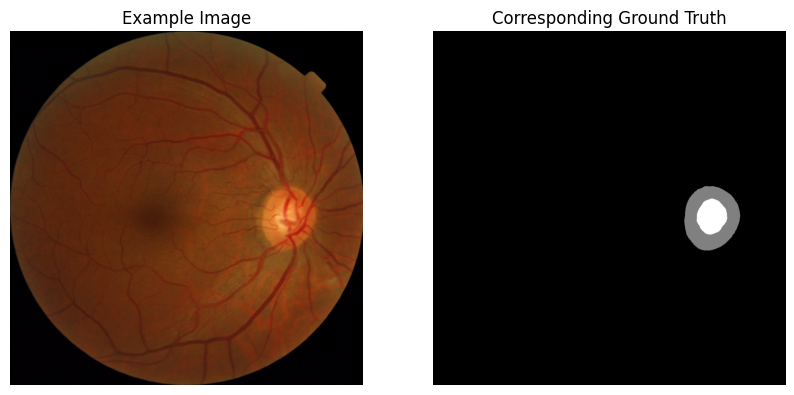

In [3]:
ground_truth_path = "ground truths1"
images_path = "images1"

image_files = sorted(os.listdir(images_path))
ground_truth_files = sorted(os.listdir(ground_truth_path))

image_files = sorted([f for f in os.listdir(images_path) if os.path.isfile(os.path.join(images_path, f))])
ground_truth_files = sorted([f for f in os.listdir(ground_truth_path) if os.path.isfile(os.path.join(ground_truth_path, f))])

# Verify alignment by printing pairs
for i in range(5):  # Example to check the first 5 pairs
    print(f"Image file: {image_files[i]}, Mask file: {ground_truth_files[i]}")


images = [cv2.imread(os.path.join(images_path, f)) for f in image_files]
ground_truths = [cv2.imread(os.path.join(ground_truth_path, f), cv2.IMREAD_GRAYSCALE) for f in ground_truth_files]

train_images, test_images, train_ground_truths, test_ground_truths = train_test_split(images, ground_truths, test_size=10, random_state=42)
print(f"Number of training images: {len(train_images)}")
print(f"Number of testing images: {len(test_images)}")


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
plt.title("Example Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(ground_truths[0], cv2.COLOR_BGR2RGB))
plt.title("Corresponding Ground Truth")
plt.axis('off')

plt.show()

In [4]:

TRAIN_LENGTH = len(train_images)
BATCH_SIZE = 8  # Or adjust based on your dataset size
STEPS_PER_EPOCH = max(1, TRAIN_LENGTH // BATCH_SIZE)  # Ensures at least 1
BUFFER_SIZE = 100
width, height = 224, 224


def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32)# Assuming masks are already [0, 1] or need conversion similar to images
    return input_image, input_mask

def preprocess_masks(mask):
    # Map 128 to 1, and everything else to 0 (assuming only two classes really exist)
    mask = tf.where(mask == 128, 1, 0)
    return mask

def load_image_and_mask(image, mask):
    image = tf.image.resize(image, [height, width])
    mask = preprocess_masks(mask)  # make sure mask values are correctly preprocessed
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    image, mask = normalize(image, mask)
    return image, mask


In [5]:

# Convert the lists to TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_ground_truths))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_ground_truths))


In [6]:

# Apply the load_image_and_mask function
train_ds = train_ds.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)


In [7]:
# Setting up the training dataset pipeline
train_ds = train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)



In [8]:



# Setting up the testing dataset pipeline
test_ds = test_ds.batch(BATCH_SIZE)


for i in range(5):
    print(f"Image file: {image_files[i]}, Mask file: {ground_truth_files[i]}")

Image file: 1.png, Mask file: 1.tif
Image file: 10.png, Mask file: 10.tif
Image file: 100.png, Mask file: 100.tif
Image file: 11.png, Mask file: 11.tif
Image file: 12.png, Mask file: 12.tif


In [9]:
# Debug function to check unique mask values
def debug_mask_values(dataset):
    for images, masks in dataset.take(1):  # Take one batch from the dataset
        print("Unique mask labels in batch:", np.unique(masks.numpy()))

# Call this function after creating your dataset but before training
debug_mask_values(train_ds)

Unique mask labels in batch: [0. 1.]


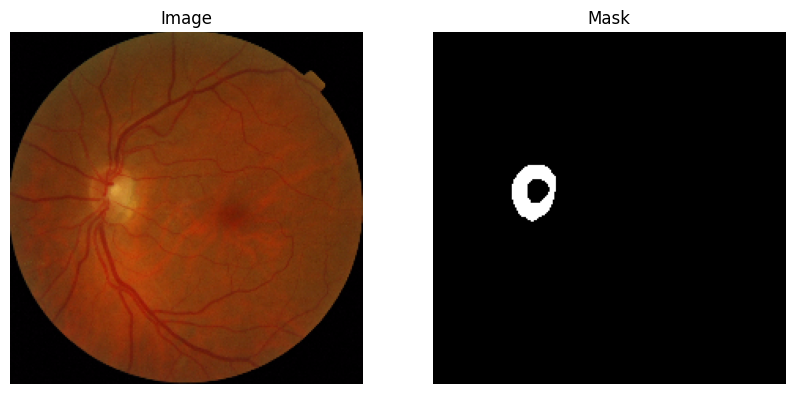

In [10]:
def display_sample(image, mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Mask')
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.show()

# Fetch one batch from the dataset
for images, masks in train_ds.take(1):
    sample_image, sample_mask = images[0], masks[0]  # Take the first example in the batch
    display_sample(sample_image.numpy(), sample_mask.numpy())  # Convert tensors to numpy arrays for visualization

In [11]:
base_model = keras.applications.vgg16.VGG16(include_top=False, input_shape=(width, height, 3))

layer_names = [
    'block1_pool',
    'block2_pool',
    'block3_pool',
    'block4_pool',
    'block5_pool',
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
base_model.trainable = False

VGG_16 = tf.keras.models.Model(base_model.input, base_model_outputs)

In [12]:


# Reset the Keras session
tf.keras.backend.clear_session()

def fcn8_decoder(convs, n_classes):
    f1, f2, f3, f4, p5 = convs

    n = 4096
    c6 = tf.keras.layers.Conv2D(n, (7, 7), activation='relu', padding='same', name="conv6")(p5)
    c7 = tf.keras.layers.Conv2D(n, (1, 1), activation='relu', padding='same', name="conv7")(c6)

    f5 = c7

    # upsample the output of the encoder
    # then crop extra pixels that were introduced
    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4, 4),  strides=(2, 2), use_bias=False)(f5)
    o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

    # load the pool 4 prediction and do a 1x1
    # convolution to reshape it to the same shape of `o` above
    o2 = f4
    o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1), activation='relu', padding='same'))(o2)

    # add the results of the upsampling and pool 4 prediction
    o = tf.keras.layers.Add()([o, o2])

    # upsample the resulting tensor of the operation you just did
    o = (tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4, 4),  strides=(2, 2), use_bias=False))(o)
    o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

    # load the pool 3 prediction and do a 1x1
    # convolution to reshape it to the same shape of `o` above
    o2 = f3
    o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1), activation='relu', padding='same'))(o2)

    # add the results of the upsampling and pool 3 prediction
    o = tf.keras.layers.Add()([o, o2])

    # upsample up to the size of the original image
    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(8, 8),  strides=(8, 8), use_bias=False)(o)

    # append a softmax to get the class probabilities
    o = tf.keras.layers.Activation('softmax')(o)
    return o


In [13]:
def segmentation_model():

    inputs = keras.layers.Input(shape=(width, height, 3))
    convs = VGG_16(inputs)
    outputs = fcn8_decoder(convs, 3)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


opt = keras.optimizers.Adam()

model = segmentation_model()
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [14]:
def display_images(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])

        if i == 0:  # Assuming the first image in the display_list is the input image
            # Convert BGR to RGB
            img = display_list[i]
            img = img[..., ::-1]  # Reverse the last (channel) dimension to switch from BGR to RGB
            plt.imshow(array_to_img(img))
        else:
            plt.imshow(array_to_img(display_list[i]))

        plt.axis('off')
    plt.show()

In [15]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_images([image[0], mask[0], create_mask(pred_mask)])
    else:
        display_images([sample_image, sample_mask,
                        create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


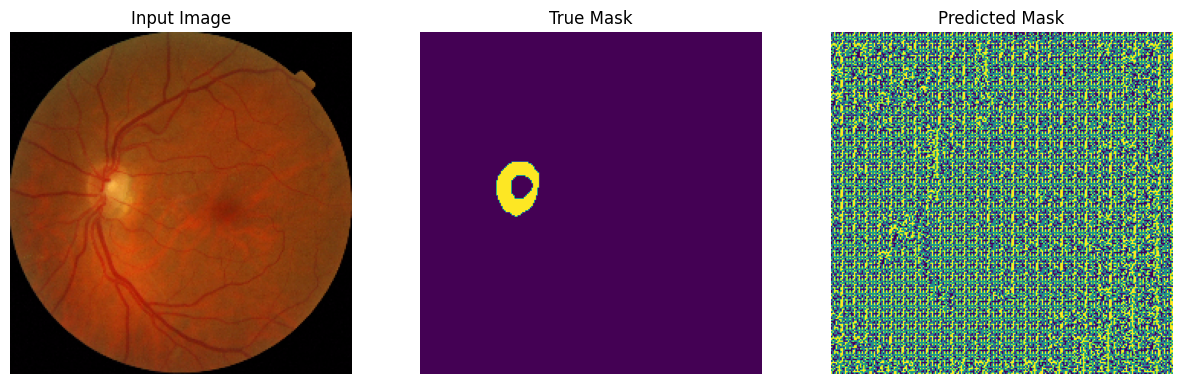

In [16]:
show_predictions()

In [17]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 10//BATCH_SIZE//VAL_SUBSPLITS

# Check if test_ds is not None
if test_ds is None:
    raise ValueError("The validation data (test_ds) is not defined or is None.")

# Calculate validation steps and ensure it's positive
validation_steps = max(1, len(test_images) // BATCH_SIZE // VAL_SUBSPLITS)
print(f"Validation steps: {validation_steps}")

# Fit the model with the train and validation data
model_history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_ds
)

Validation steps: 1
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.3286 - loss: 1.1208 - val_accuracy: 0.3929 - val_loss: 1.0673
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4358 - loss: 1.0405 - val_accuracy: 0.5614 - val_loss: 0.9182
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6112 - loss: 0.8504 - val_accuracy: 0.7435 - val_loss: 0.6361
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7803 - loss: 0.5605 - val_accuracy: 0.8995 - val_loss: 0.3297
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9218 - loss: 0.2633 - val_accuracy: 0.9595 - val_loss: 0.1077
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9682 - loss: 0.0859 - val_accuracy: 0.9844 - val_loss: 0.0472
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9841 - loss: 0.0473 - val_accuracy: 0.9848 - val_loss: 0.0405
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9849 - loss: 0.0382 - val_accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


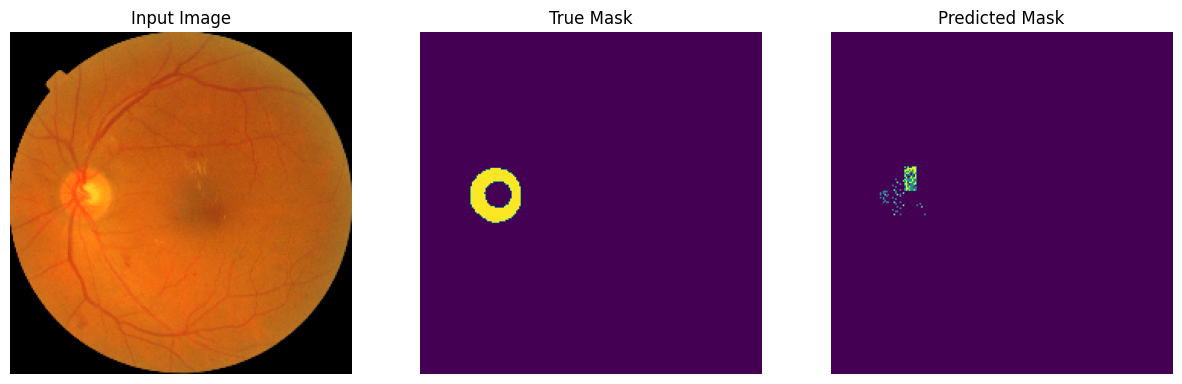

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


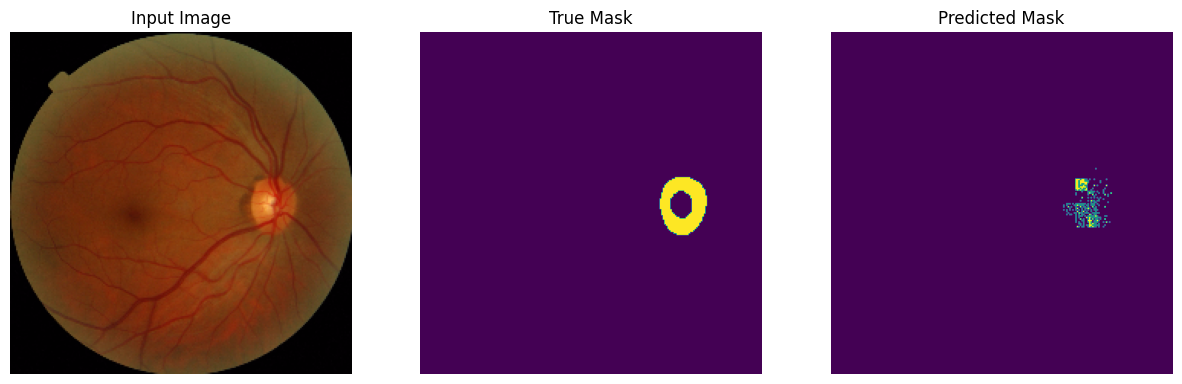

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


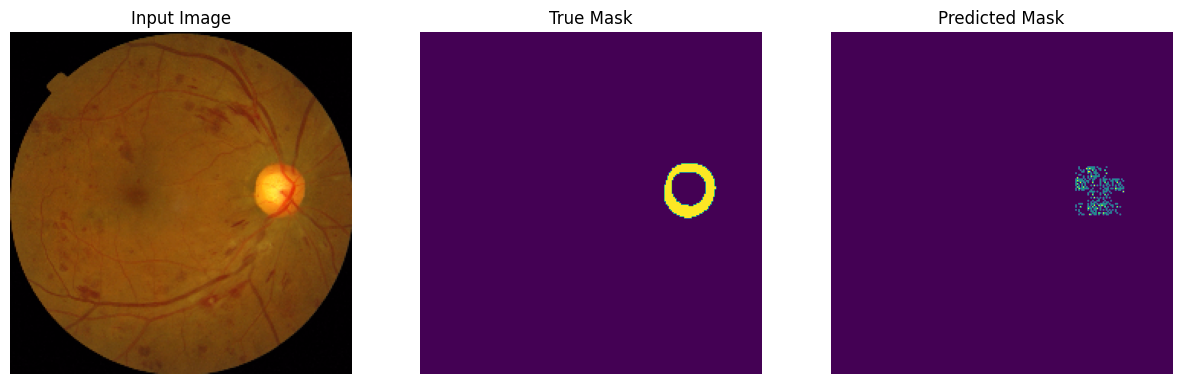

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


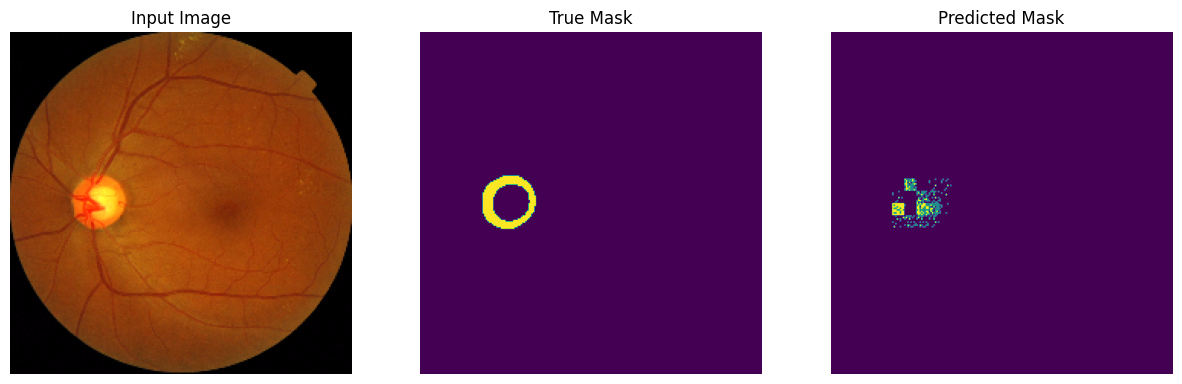

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


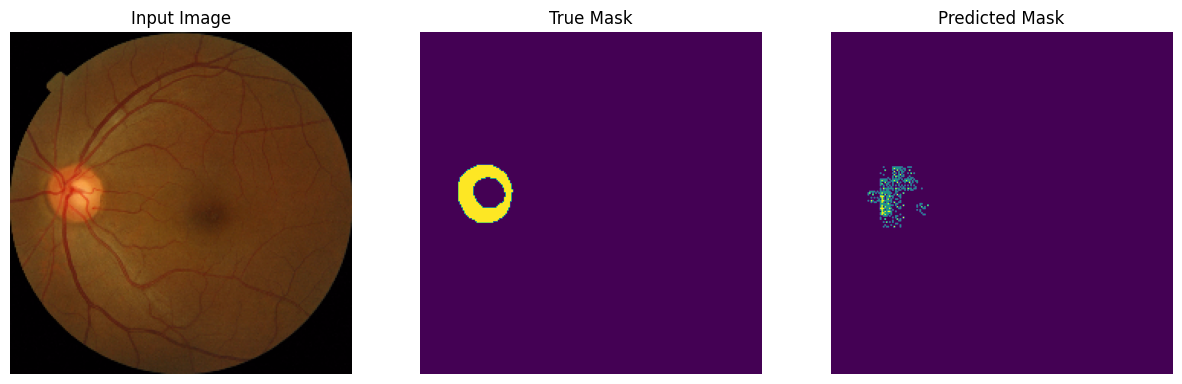

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


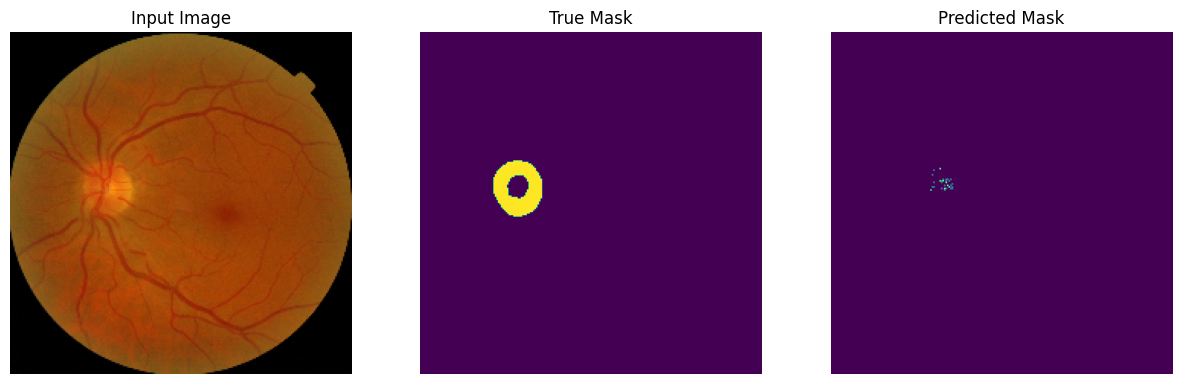

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


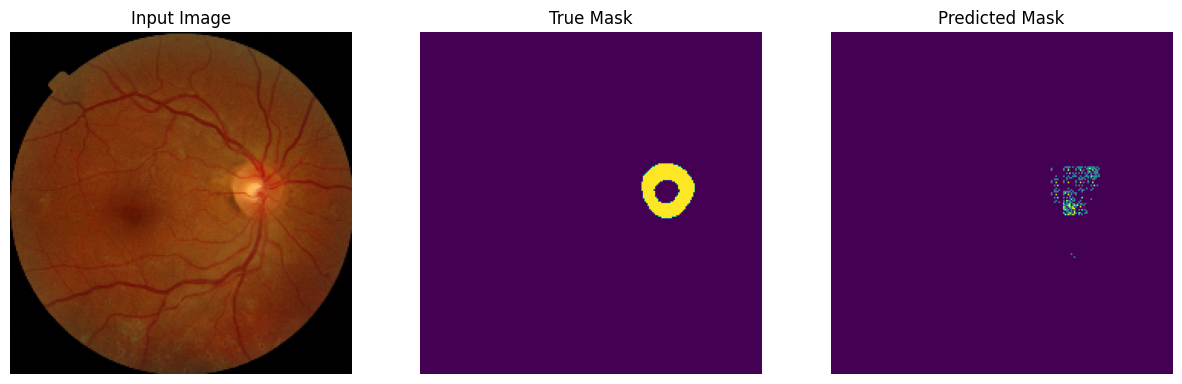

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


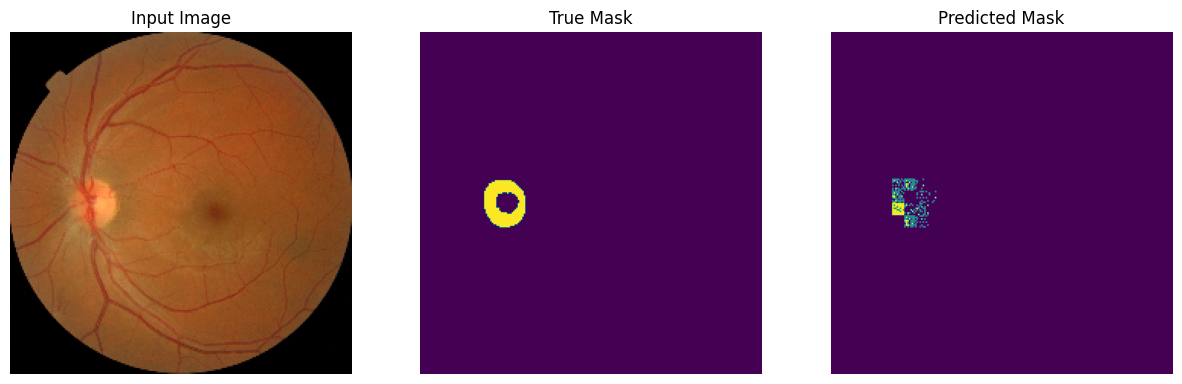

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


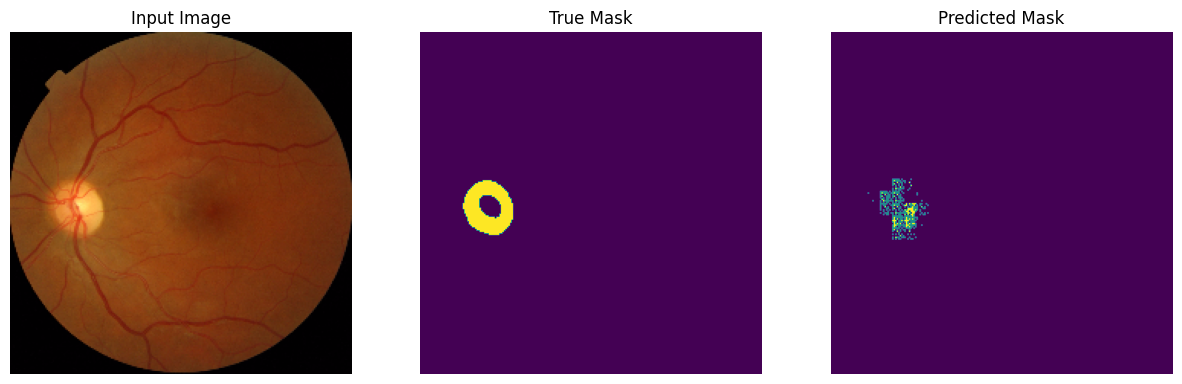

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


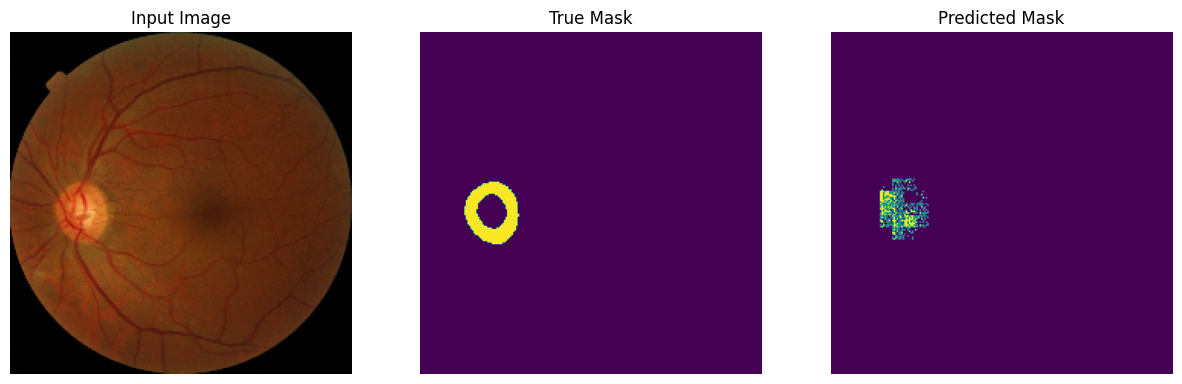

In [18]:

#model.save('unet_model.h5')

# Load the model
#model.load('unet_model.h5')



def display_images(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])

        if i == 0:  # Assuming the first image in the display_list is the input image
            # Convert BGR to RGB
            img = display_list[i]
            img = img[..., ::-1]  # Reverse the last (channel) dimension to switch from BGR to RGB
            plt.imshow(array_to_img(img))
        else:
            plt.imshow(array_to_img(display_list[i]))

        plt.axis('off')
    plt.show()


def display_sample(image, mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Mask')
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.show()

# Function to create mask from prediction
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

# Function to show predictions for the entire dataset
def show_predictions(dataset):
    for images, masks in dataset:
        for image, mask in zip(images, masks):
            pred_mask = model.predict(image[tf.newaxis, ...])
            display_images([image, mask, create_mask(pred_mask)])

# Show predictions for the entire train_ds dataset
show_predictions(test_ds)